## Setup & Dependencies

In [1]:
!pip install pandas numpy nltk spacy scikit-learn transformers beautifulsoup4 matplotlib seaborn swifter emoji==0.6.0
!python -m spacy download en_core_web_trf

import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import nltk
import spacy
import swifter
from transformers import pipeline, AutoTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from google.colab import drive


drive.mount('/content/drive')

# Set plotting style
sns.set(style='ticks', color_codes=True, font_scale=0.8)
plt.rcParams['figure.figsize'] = (6, 4)
%config InlineBackend.figure_format = 'retina'

# NLTK downloads
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Load spaCy model
nlp = spacy.load("en_core_web_trf")

print("Setup complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.4/457.4 MB 642.9 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_trf')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Setup complete!


## Load Data

In [2]:
def load_data(news_files, transfer_files):
    """Load and combine news and transfer datasets from Google Drive."""
    news_dfs = [pd.read_csv(f, low_memory=False) for f in news_files]
    news_df = pd.concat(news_dfs, ignore_index=True)
    transfer_df1 = pd.read_csv(transfer_files[0], low_memory=False)
    transfer_df2 = pd.read_csv(transfer_files[1], low_memory=False)
    transfer_df3 = pd.read_csv(transfer_files[2], low_memory=False)
    print("News data loaded:", news_df.shape)
    print("Transfer data loaded:", transfer_df1.shape, transfer_df2.shape, transfer_df3.shape)
    return news_df, transfer_df1, transfer_df2, transfer_df3

news_files = [
    '/content/drive/MyDrive/Dataset/Dataset/News Database/Copy of miao_feed_data.csv',
    '/content/drive/MyDrive/Dataset/Dataset/News Database/Copy of news_feed_data.csv'
]
transfer_files = [
    '/content/drive/MyDrive/Dataset/Dataset/Transfer History/player_detail.csv',
    '/content/drive/MyDrive/Dataset/Dataset/Transfer History/tm_player_market_value_development.csv',
    '/content/drive/MyDrive/Dataset/Dataset/Transfer History/tm_player_transfer_history.csv'
]

news_df, transfer_df1, transfer_df2, transfer_df3 = load_data(news_files, transfer_files)
print("Full news data loaded:", news_df.shape)
print("Columns:", news_df.columns.tolist())
print("First row content:", news_df['content'].iloc[0] if 'content' in news_df.columns else "No content column")

News data loaded: (212853, 18)
Transfer data loaded: (20415, 13) (280334, 8) (151436, 19)
Full news data loaded: (212853, 18)
Columns: ['url', 'title', 'author', 'content', 'date', 'title_image', 'spider_type', 'summary', 'mini_summary_cn', 'keywords', 'summary_cn', 'title_cn', 'mini_summary', 'file_name', 'chunks', 'translations', 'video_generated', 'categories']
First row content: <html><body><div><div class="sc-294a6039-6 fbDgKK article-content-container bodytext1"><p><span>AC Milan head coach </span><span class="yKMVIe" role="heading" aria-level="1">Stefano Pioli </span><span>says Rafael Leao is “becoming a champion” as the winger helped his side progress to the Champions League semi-finals after overcoming Napoli. </span></p><p><span>Following a 1-1 draw at </span><span>Stadio Diego Armando Maradona, Milan progressed to the semi-finals of the European competition after winning 2-1 across two legs. </span></p><p><span>Leao, 23, produced a man of the match performance on the night a

In [3]:
# Check missing values
missing_values = news_df.isnull().sum()
print("\nMissing values in news_df:")
print(missing_values)

# Percentage of missing values
missing_percent = (news_df.isnull().sum() / len(news_df)) * 100
print("\nPercentage of missing values in news_df:")
print(missing_percent)


Missing values in news_df:
url                     0
title                  23
author                  0
content                 0
date                   91
title_image        137512
spider_type             0
summary            140388
mini_summary_cn    198069
keywords           140388
summary_cn         198068
title_cn           140415
mini_summary       147398
file_name            9092
chunks             148660
translations       148660
video_generated    206635
categories          77847
dtype: int64

Percentage of missing values in news_df:
url                 0.000000
title               0.010806
author              0.000000
content             0.000000
date                0.042753
title_image        64.604210
spider_type         0.000000
summary            65.955378
mini_summary_cn    93.054361
keywords           65.955378
summary_cn         93.053892
title_cn           65.968062
mini_summary       69.248730
file_name           4.271493
chunks             69.841628
translations  

## Preprocess News Data
This cleans the news text and extracts player names from the full 212,853 rows.





In [4]:
def preprocess_text(text):
    """Clean text by removing HTML, special chars, and extra spaces."""
    text = str(text)
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())
    return re.sub(r'\s+', ' ', text).strip()

In [5]:
def extract_player_name(text, player_list):
    """Extract first matching player name (case-insensitive)."""
    text_lower = text.lower()  # To know if text is lowercase
    for player in player_list:
        if player.lower() in text_lower:  # Case insensitive match
            return player
    return None

In [6]:
# Process full dataset
print("Starting full cleaning...")
news_df['processed_text'] = news_df['content'].apply(preprocess_text)
print("After cleaning, total rows:", news_df.shape[0])

Starting full cleaning...
After cleaning, total rows: 212853


In [7]:
# Articles filter under 2000 characters
news_df = news_df[news_df['processed_text'].str.len() < 2000]
print("After length filter (<2000 chars):", news_df.shape[0])
news_df.dropna(subset=['processed_text'], inplace=True)
print("After dropping NaN processed_text:", news_df.shape[0])

After length filter (<2000 chars): 63328
After dropping NaN processed_text: 63328


In [8]:
# Player names Extraction
player_names = transfer_df1['Name'].dropna().unique().tolist()
print("Number of unique player names:", len(player_names))
print("Sample player names:", player_names[:5])  # Show first 5 names

Number of unique player names: 19784
Sample player names: ['Thibaut Courtois', 'Andriy Lunin', 'Kepa Arrizabalaga', 'Éder Militão', 'David Alaba']


In [9]:
# Test on sample
sample_df = news_df.head(1000).copy()
sample_df['player_name'] = sample_df['processed_text'].apply(lambda x: extract_player_name(x, player_names))
print("Sample rows with player matches:", sample_df['player_name'].notna().sum())
print(sample_df[['processed_text', 'player_name']].head(10))

Sample rows with player matches: 929
                                       processed_text         player_name
0   ac milan head coach stefano pioli says rafael ...      Olivier Giroud
12  sevilla head coach jose luis mendilibar is not...       Harry Maguire
15  manchester united forward marcus rashford has ...     Marcel Sabitzer
24  manchester united manager erik ten hag wants h...       Harry Maguire
25  manchester city midfielder bernardo silva says...      Joshua Kimmich
38  inter milan head coach simone inzaghi has prai...               Portu
45  chelsea will play wrexham in chapel hill north...               Portu
53  fabio paraticis appeal against his ban from fo...                Mina
77  imagealejandro garnacho portrait argentina fly...  Alejandro Garnacho
89  leeds united head coach javi gracia says he is...         Tyler Adams


In [10]:
# Run it in full
news_df['player_name'] = news_df['processed_text'].apply(lambda x: extract_player_name(x, player_names))
print("Rows with player matches:", news_df['player_name'].notna().sum())

Rows with player matches: 56736


In [11]:
# Keep rows with matches
news_df.dropna(subset=['player_name'], inplace=True)
print("News cleaned:", news_df.shape)
print(news_df[['player_name', 'processed_text']].head())

News cleaned: (56736, 20)
        player_name                                     processed_text
0    Olivier Giroud  ac milan head coach stefano pioli says rafael ...
12    Harry Maguire  sevilla head coach jose luis mendilibar is not...
15  Marcel Sabitzer  manchester united forward marcus rashford has ...
24    Harry Maguire  manchester united manager erik ten hag wants h...
25   Joshua Kimmich  manchester city midfielder bernardo silva says...


## Preprocess Transfer Data
Purpose: Combine and clean the three transfer datasets into one DataFrame (transfer_df) with player details, latest transfer info, and highest market value

In [12]:
def clean_transfer_data(df1, df2, df3):
    """Clean and merge transfer datasets."""
    # Latest transfers from transfer history
    df3['date'] = pd.to_datetime(df3['date'], errors='coerce')
    latest_transfers = df3.sort_values('date', ascending=False).drop_duplicates('player_id', keep='first')

    # Highest market values from market value development
    df2['datum_mw'] = pd.to_datetime(df2['datum_mw'], errors='coerce')
    highest_values = df2.sort_values('mw', ascending=False).drop_duplicates('player_id', keep='first')

    # Merge player detail with highest values and latest transfers
    transfer_df = df1.merge(highest_values, on='player_id', how='left')
    transfer_df = transfer_df.merge(latest_transfers, on='player_id', how='left')

    # Clean market value and fee columns
    transfer_df['marketValue'] = transfer_df['marketValue'].fillna('€0').replace('-', '€0')
    transfer_df['marketValue'] = transfer_df['marketValue'].replace({'€': '', 'm': '000000', 'k': '000'}, regex=True).astype(float)
    transfer_df['fee'] = transfer_df['fee'].fillna('€0').replace('-', '€0')
    transfer_df['fee_numeric'] = transfer_df['fee'].str.replace('€', '').str.replace('m', '000000').str.replace('k', '000')
    transfer_df['fee_numeric'] = pd.to_numeric(transfer_df['fee_numeric'], errors='coerce').fillna(0)

    # Drop negatives and NaNs
    transfer_df = transfer_df[transfer_df['marketValue'] >= 0]
    transfer_df.dropna(subset=['Name', 'player_id'], inplace=True)

    return transfer_df

In [13]:
# Clean transfer data
transfer_df = clean_transfer_data(transfer_df1, transfer_df2, transfer_df3)
print("Transfer data cleaned:", transfer_df.shape)
print(transfer_df[['Name', 'marketValue', 'fee_numeric']].head(10))

Transfer data cleaned: (20415, 39)
                Name  marketValue  fee_numeric
0   Thibaut Courtois         65.0         35.0
1       Andriy Lunin          2.7          0.0
2  Kepa Arrizabalaga         12.0          0.0
3       Éder Militão         50.0         50.0
4        David Alaba         55.0          0.0
5    Antonio Rüdiger         40.0          0.0
6    Nacho Fernández          1.5          0.0
7      Ferland Mendy         30.0         48.0
8        Fran García         12.0          5.0
9    Daniel Carvajal         10.0          6.5


## Sentiment Analysis & NLP
Now, let’s analyze the news articles for sentiment and entities. we crash proof here and saved because colab free kept crashing, so we partially save all the sentiment analysis.

In [14]:
# For colab crashing when running for all, so crash proof was implemented
def get_sentiment(texts, model_name='finiteautomata/bertweet-base-sentiment-analysis', max_length=128):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    sentiment_pipeline = pipeline('sentiment-analysis', model=model_name, tokenizer=tokenizer)
    sentiments = sentiment_pipeline(texts, max_length=max_length, truncation=True, padding=True, batch_size=16)
    return [s['label'] for s in sentiments]

In [15]:
def extract_entities(text):
    doc = nlp(text)
    players = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    clubs = [ent.text for ent in doc.ents if ent.text not in {'Premier League', 'FIFA'} and ent.label_ == 'ORG']
    return players, clubs

In [16]:
# Batch sentiment with error handling
def batch_sentiment_with_save(df, chunk_size=1000, output_file='/content/drive/MyDrive/news_df_partial.csv'):
    """Process sentiment in chunks and save after each."""
    sentiments = []
    for i in range(0, len(df), chunk_size):
        chunk = df['processed_text'].iloc[i:i+chunk_size].tolist()
        print(f"Processing chunk {i//chunk_size + 1} of {len(df)//chunk_size + 1}")
        chunk = [str(t) if pd.notna(t) else "" for t in chunk]
        if not chunk or all(t.strip() == "" for t in chunk):
            print(f"Chunk {i//chunk_size + 1} is empty or all blank!")
            sentiments.extend(["NEU"] * len(chunk))
            continue
        try:
            chunk_sentiments = get_sentiment(chunk)
            sentiments.extend(chunk_sentiments)
            # Saving partial results incase colab crash
            temp_df = df.iloc[:len(sentiments)].copy()
            temp_df['sentiment'] = sentiments
            temp_df.to_csv(output_file, index=False)
            print(f"Saved partial results up to chunk {i//chunk_size + 1}")
        except Exception as e:
            print(f"Error in chunk {i//chunk_size + 1}: {e}")
            sentiments.extend(["NEU"] * len(chunk))
    return sentiments

In [17]:
# Subset 5,000 rows for analysis
news_df_processed = news_df.sample(n=5000, random_state=42)
print("Processed news_df shape:", news_df_processed.shape)

Processed news_df shape: (5000, 20)


In [18]:
# Run sentiment with saving
print("Starting sentiment analysis...")
news_df_processed['sentiment'] = batch_sentiment_with_save(news_df_processed, chunk_size=1000)
print("Sentiment added:", news_df_processed['sentiment'].value_counts())

Starting sentiment analysis...
Processing chunk 1 of 6


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Device set to use cpu


model.safetensors:   0%|          | 0.00/540M [00:00<?, ?B/s]

Saved partial results up to chunk 1
Processing chunk 2 of 6


Device set to use cpu


Saved partial results up to chunk 2
Processing chunk 3 of 6


Device set to use cpu


Saved partial results up to chunk 3
Processing chunk 4 of 6


Device set to use cpu


Saved partial results up to chunk 4
Processing chunk 5 of 6


Device set to use cpu


Saved partial results up to chunk 5
Sentiment added: sentiment
NEU    3556
POS    1206
NEG     238
Name: count, dtype: int64


In [19]:
print("Sentiment check:", news_df_processed['sentiment'].value_counts())

Sentiment check: sentiment
NEU    3556
POS    1206
NEG     238
Name: count, dtype: int64


In [20]:
# Extraction entity with NaN handling
def extract_entities(text):
    # Convert NaN/float to empty string
    if pd.isna(text):
        return [], []  # Return empty lists for players and clubs
    doc = nlp(text)
    players = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    clubs = [ent.text for ent in doc.ents if ent.text not in {'Premier League', 'FIFA'} and ent.label_ == 'ORG']
    return players, clubs

In [21]:
print("Extracting entities from titles...")
news_df_processed[['player_entities', 'club_entities']] = news_df_processed['title'].apply(lambda x: pd.Series(extract_entities(x)))
print(news_df_processed[['title', 'player_entities', 'club_entities']].head())

Extracting entities from titles...
                                                    title  \
9464    Varane named Man United captain vs Lyon in fir...   
188597  Brighton confirm departure of former Man Unite...   
164870  QPR keen to bring back Aston Villa man, report...   
40860     ‘City well beaten and should have lost by more’   
73523   Rodri makes 'scared' Man City claim and names ...   

                player_entities                    club_entities  
9464    [Varane, Lyon, Maguire]                     [Man United]  
188597                       []  [Brighton, Man United, Chelsea]  
164870                       []                    [Aston Villa]  
40860                        []                               []  
73523                   [Rodri]              [Man City, Chelsea]  


In [22]:
# verify and Saving
print("Sentiment check:", news_df_processed['sentiment'].value_counts())
print("Final shape:", news_df_processed.shape)

# Final save
news_df_processed.to_csv('/content/drive/MyDrive/news_df_processed_with_sentiment_and_entities.csv', index=False)
print("Saved processed news_df with sentiment and entities to Google Drive!")

Sentiment check: sentiment
NEU    3556
POS    1206
NEG     238
Name: count, dtype: int64
Final shape: (5000, 23)
Saved processed news_df with sentiment and entities to Google Drive!


## Merge and Recommend
Now we’ll merge news_df_processed with transfer_df and find undervalued players.

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load data
news_df_processed = pd.read_csv('/content/drive/MyDrive/news_df_processed_with_sentiment_and_entities.csv', low_memory=False)
player_detail = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset/Transfer History/player_detail.csv', low_memory=False)
transfer_history = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset/Transfer History/tm_player_transfer_history.csv', low_memory=False)
market_values = pd.read_csv('/content/drive/MyDrive/Dataset/Dataset/Transfer History/tm_player_market_value_development.csv', low_memory=False)

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [3]:
def merge_data(news_df, player_df, transfer_df, value_df):
    transfer_df = transfer_df[(transfer_df['date'] >= '2022-01-01') & (transfer_df['date'] <= '2024-12-31')]
    print("Filtered transfer_history shape (2022-2024):", transfer_df.shape)
    news_df['player_match'] = news_df['player_entities'].apply(lambda x: eval(x)[0] if eval(x) else None)
    merged_temp1 = news_df.merge(player_df[['Name', 'player_id']], left_on='player_match', right_on='Name', how='inner')
    merged_temp2 = merged_temp1.merge(transfer_df[['player_id', 'Transfer Fee', 'to_clubName', 'date']], on='player_id', how='inner')
    value_df = value_df.sort_values('datum_mw', ascending=False).drop_duplicates('player_id')
    merged_df = merged_temp2.merge(value_df[['player_id', 'mw']], on='player_id', how='inner')
    merged_df.drop_duplicates(subset=['player_id'], inplace=True)
    merged_df.dropna(subset=['Transfer Fee', 'mw'], inplace=True)
    return merged_df

In [4]:
def recommend_players(df):
    undervalued = df[(df['sentiment'] == 'POS') & (df['mw'] < df['Transfer Fee']) & (df['mw'] > 1000000)]
    undervalued['overpayment'] = undervalued['Transfer Fee'] - undervalued['mw']
    # Add basic summaries
    undervalued['situation'] = undervalued.apply(
        lambda row: f"{row['player_match']}: Transferred to {row['to_clubName']} for €{row['Transfer Fee']/1e6:.1f}M in {row['date_y'][:4]}, now valued at €{row['mw']/1e6:.1f}M. Positive news suggests untapped potential despite €{row['overpayment']/1e6:.1f}M overpayment.", axis=1)
    return undervalued[['player_match', 'player_id', 'mw', 'Transfer Fee', 'overpayment', 'sentiment', 'to_clubName', 'date_y', 'situation']].sort_values('overpayment', ascending=False)

In [5]:
merged_df = merge_data(news_df_processed, player_detail, transfer_history, market_values)
print("Merged data shape:", merged_df.shape)
print(merged_df[['player_match', 'player_id', 'sentiment', 'mw', 'Transfer Fee', 'date_y']].head())
recommendations = recommend_players(merged_df)
print("Recommended players (2022-2024, ranked with summaries):")
print(recommendations)

Filtered transfer_history shape (2022-2024): (38419, 19)
Merged data shape: (219, 30)
     player_match  player_id sentiment          mw  Transfer Fee      date_y
0       Dele Alli     207929       NEU   5000000.0           0.0  2023-06-30
3     Tyler Adams     332705       NEU  18000000.0    26900000.0  2023-08-20
5   Carlos Baleba     973085       POS  20000000.0    27000000.0  2023-08-29
8  Tyrell Malacia     339340       NEG  18000000.0    15000000.0  2022-07-05
9   Scott McKenna     255906       NEU  10000000.0           0.0  2024-06-30
Recommended players (2022-2024, ranked with summaries):
           player_match  player_id          mw  Transfer Fee  overpayment  \
37               Antony     602105  28000000.0    95000000.0   67000000.0   
871      Marc Cucurella     284857  25000000.0    65300000.0   40300000.0   
976       Ferran Torres     398184  35000000.0    55000000.0   20000000.0   
565         Lucas Digne     126664  12000000.0    30000000.0   18000000.0   
980        

<ipython-input-4-08329c8cd930>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued['overpayment'] = undervalued['Transfer Fee'] - undervalued['mw']
<ipython-input-4-08329c8cd930>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  undervalued['situation'] = undervalued.apply(


## Patterns

In [6]:
# Analysis Pattern
patterns = {
    "POS + Overpayment": len(recommendations),
    "NEG + mw < fee": len(merged_df[(merged_df['sentiment'] == 'NEG') & (merged_df['mw'] < merged_df['Transfer Fee'])]),
    "POS + mw > fee": len(merged_df[(merged_df['sentiment'] == 'POS') & (merged_df['mw'] > merged_df['Transfer Fee'])]),
}
print("Patterns identified:")
for pattern, count in patterns.items():
    print(f"{pattern}: {count} players")

Patterns identified:
POS + Overpayment: 17 players
NEG + mw < fee: 1 players
POS + mw > fee: 40 players


## Regression Analysis


In [7]:
def prepare_regression_data(df):
    # Initialize LabelEncoder
    le = LabelEncoder()

    # Encode categorical variables
    df['sentiment_encoded'] = le.fit_transform(df['sentiment'])
    df['club_encoded'] = le.fit_transform(df['to_clubName'].fillna('Unknown'))  # Handle NaN with 'Unknown'

    # Extract year from date_y (assuming it's a string like '2022-07-01')
    df['year'] = pd.to_datetime(df['date_y'], errors='coerce').dt.year.fillna(2022).astype(int)  # fill with 2022 if NaN

    # Define features and target
    features = ['mw', 'sentiment_encoded', 'club_encoded', 'year']
    target = 'Transfer Fee'

    # Create feature matrix X and target vector y
    X = df[features]
    y = df[target]

    # Check for NaN in X or y
    X = X.fillna(0)  # Replace NaN with 0 for simplicity (could use mean/median instead)
    y = y.fillna(y.mean())  # Replace NaN in target with mean

    return X, y, le

In [8]:
# Data Spliting
X, y, label_encoder = prepare_regression_data(merged_df)
print("Features used in regression:", X.columns.tolist())
print("Feature sample:\n", X.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Features used in regression: ['mw', 'sentiment_encoded', 'club_encoded', 'year']
Feature sample:
            mw  sentiment_encoded  club_encoded  year
0   5000000.0                  1            33  2023
3  18000000.0                  1            20  2023
5  20000000.0                  2            22  2023
8  18000000.0                  0            60  2022
9  10000000.0                  1            67  2024


In [9]:
# Models Initialization
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
ensemble_model = VotingRegressor(estimators=[('lr', lr_model), ('rf', rf_model), ('gb', gb_model)])

In [10]:
# Train models
print("Training regression models...")
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)
ensemble_model.fit(X_train, y_train)

Training regression models...


VotingRegressor(estimators=[('lr', LinearRegression()),
                            ('rf', RandomForestRegressor(random_state=42)),
                            ('gb', GradientBoostingRegressor(random_state=42))])

In [11]:
# Make predictions
lr_pred = lr_model.predict(X_test)
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)
ensemble_pred = ensemble_model.predict(X_test)

In [14]:
# Evaluate models
import numpy as np # Import numpy with alias np
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)  # Compute MSE
    rmse = np.sqrt(mse)  # Take square root for RMSE using np
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: €{rmse/1e6:.2f}M, R²: {r2:.4f}")
    return rmse, r2

In [15]:
# Evaluate models
print("\nModel Performance:")
lr_rmse, lr_r2 = evaluate_model(y_test, lr_pred, "Linear Regression")
rf_rmse, rf_r2 = evaluate_model(y_test, rf_pred, "Random Forest")
gb_rmse, gb_r2 = evaluate_model(y_test, gb_pred, "Gradient Boosting")
ensemble_rmse, ensemble_r2 = evaluate_model(y_test, ensemble_pred, "Ensemble")


Model Performance:
Linear Regression - RMSE: €14.54M, R²: 0.3563
Random Forest - RMSE: €16.38M, R²: 0.1831
Gradient Boosting - RMSE: €15.75M, R²: 0.2450
Ensemble - RMSE: €15.26M, R²: 0.2908


In [18]:
# Best model Identification
models_performance = {
    "Linear Regression": (lr_rmse, lr_r2),
    "Random Forest": (rf_rmse, rf_r2),
    "Gradient Boosting": (gb_rmse, gb_r2),
    "Ensemble": (ensemble_rmse, ensemble_r2)
}

In [19]:
best_model_rmse = min(models_performance.items(), key=lambda x: x[1][0])
best_model_r2 = max(models_performance.items(), key=lambda x: x[1][1])
print(f"\nBest Model by RMSE: {best_model_rmse[0]} with RMSE: €{best_model_rmse[1][0]/1e6:.2f}M")
print(f"Best Model by R²: {best_model_r2[0]} with R²: {best_model_r2[1][1]:.4f}")


Best Model by RMSE: Linear Regression with RMSE: €14.54M
Best Model by R²: Linear Regression with R²: 0.3563


## Visualizations
compelling chart to highlight undervalued players visually

In [20]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt

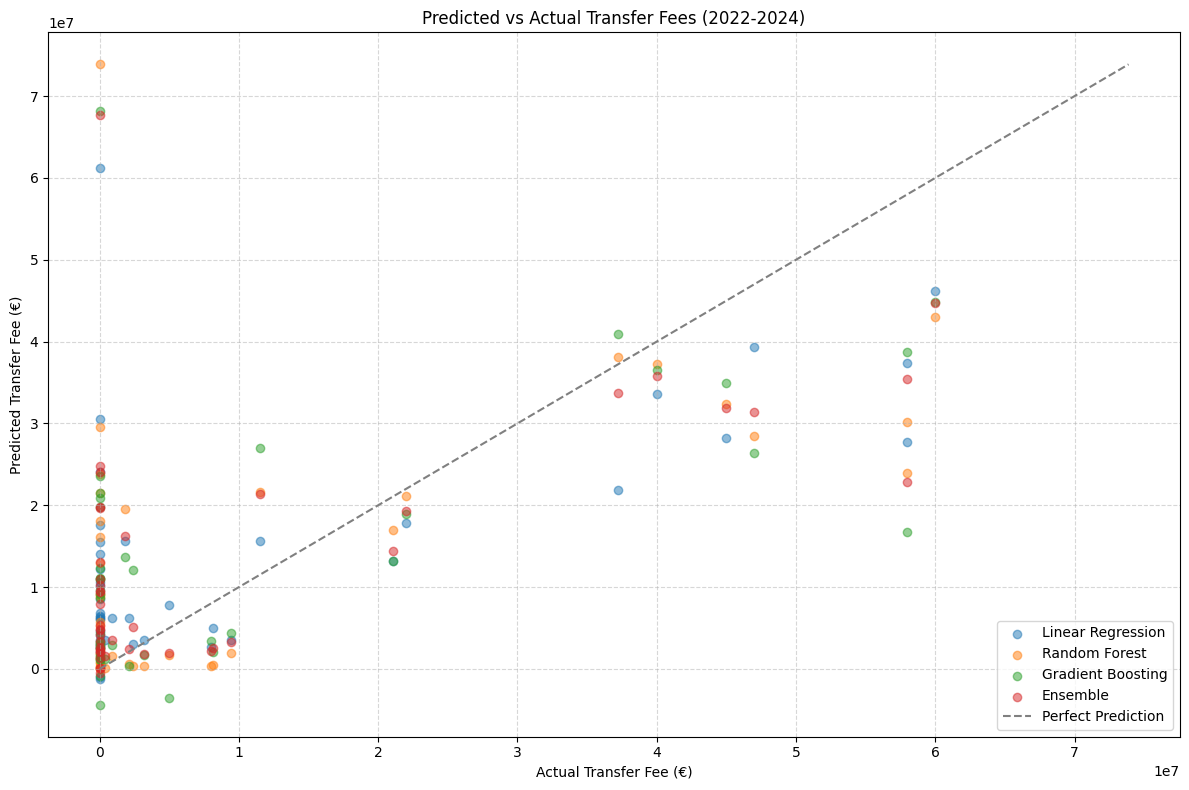

In [22]:
plt.figure(figsize=(12, 8))
plt.scatter(y_test, lr_pred, label='Linear Regression', alpha=0.5)
plt.scatter(y_test, rf_pred, label='Random Forest', alpha=0.5)
plt.scatter(y_test, gb_pred, label='Gradient Boosting', alpha=0.5)
plt.scatter(y_test, ensemble_pred, label='Ensemble', alpha=0.5)
max_val = max(y_test.max(), max(lr_pred.max(), rf_pred.max(), gb_pred.max(), ensemble_pred.max()))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Perfect Prediction')
plt.xlabel('Actual Transfer Fee (€)')
plt.ylabel('Predicted Transfer Fee (€)')
plt.title('Predicted vs Actual Transfer Fees (2022-2024)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [23]:
# Random Forest Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nRandom Forest Feature Importance:")
print(feature_importance)


Random Forest Feature Importance:
             Feature  Importance
0                 mw    0.748438
2       club_encoded    0.133506
3               year    0.066611
1  sentiment_encoded    0.051445


<ipython-input-24-dfe50f23d947>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


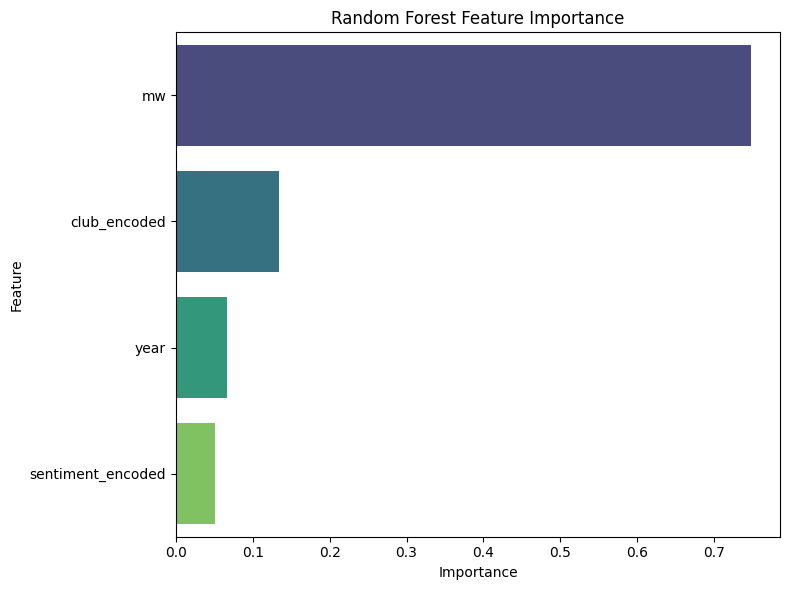

In [24]:
# feature importance Bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.tight_layout()
plt.show()

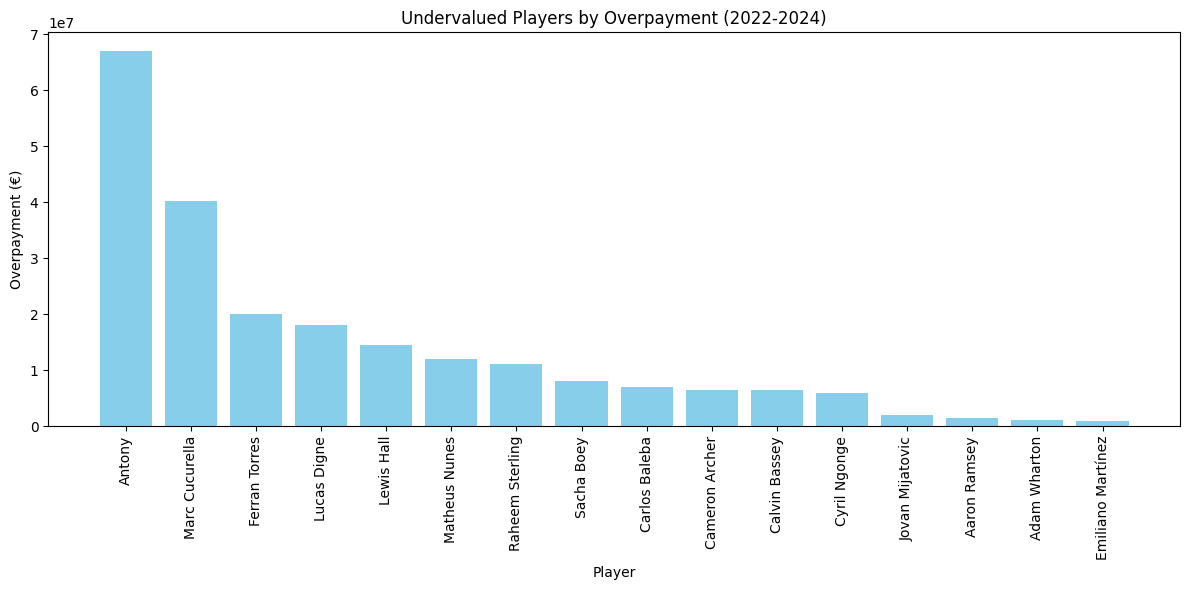

In [25]:
# Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(recommendations['player_match'], recommendations['overpayment'], color='skyblue')
plt.xticks(rotation=90)
plt.xlabel('Player')
plt.ylabel('Overpayment (€)')
plt.title('Undervalued Players by Overpayment (2022-2024)')
plt.tight_layout()
plt.show()

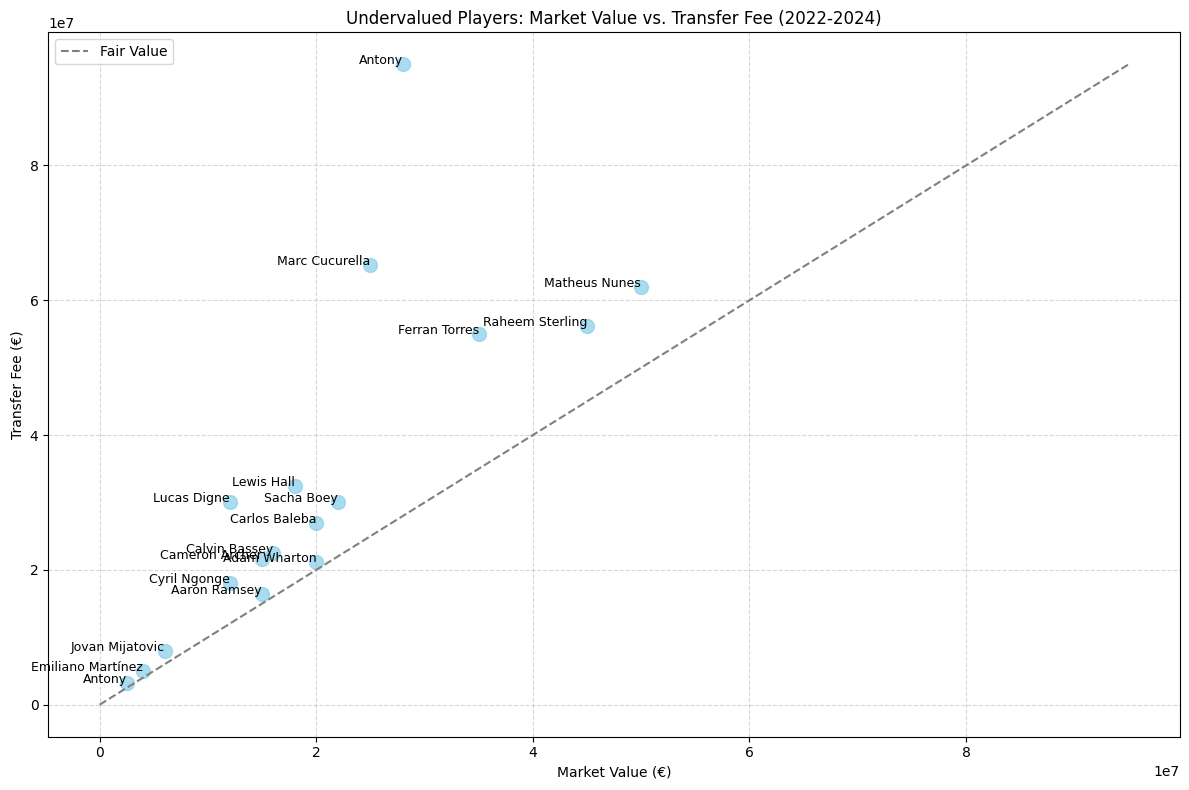

In [26]:
# Scatter Plot
plt.figure(figsize=(12, 8))
plt.scatter(recommendations['mw'], recommendations['Transfer Fee'], color='skyblue', s=100, alpha=0.7)
max_val = max(recommendations['Transfer Fee'].max(), recommendations['mw'].max())
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Fair Value')
for i, row in recommendations.iterrows():
    plt.text(row['mw'], row['Transfer Fee'], row['player_match'], fontsize=9, ha='right')
plt.xlabel('Market Value (€)')
plt.ylabel('Transfer Fee (€)')
plt.title('Undervalued Players: Market Value vs. Transfer Fee (2022-2024)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()